In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce
from scipy.stats import pointbiserialr, spearmanr
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler, RobustScaler
from catboost import CatBoostClassifier

In [2]:
data = pd.read_csv('data/adult.csv')
data.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


#### Построим гистограмму значений для каждой непрерывной функции

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launche

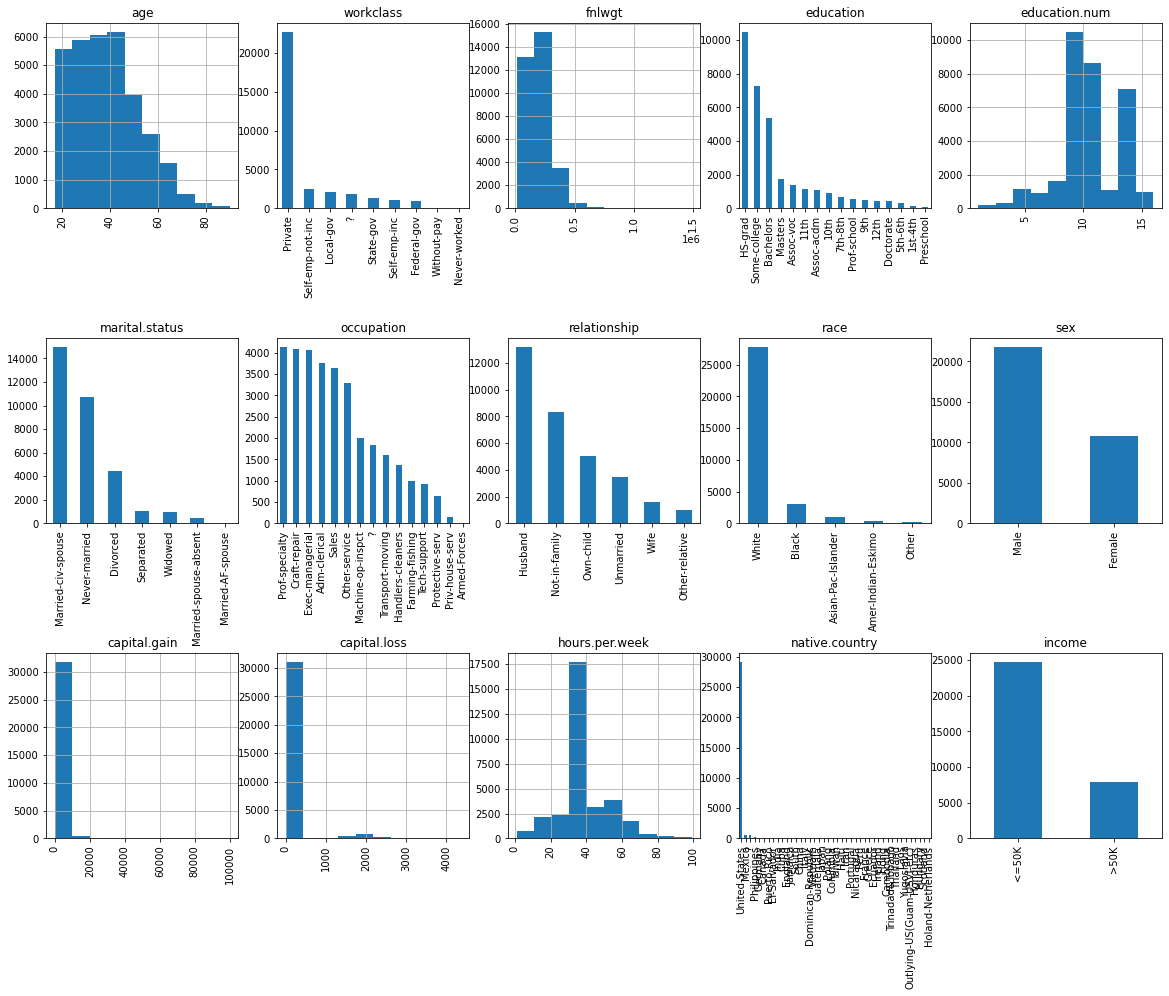

In [3]:
fig = plt.figure(figsize=(20,15))
cols = 5
rows = float(data.shape[1]) / cols
for i, column in enumerate(data.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    if data.dtypes[column] == 'object':
        data[column].value_counts().plot(kind="bar", axes=ax)
    else:
        data[column].hist(axes=ax)
        plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)

In [4]:
first_class = data[data['income'] == '<=50K'].shape[0]
second_class = data[data['income'] == '>50K'].shape[0]

print(f'Individuals making at most $50.000: {first_class}')
print(f'Individuals making more than $50.000: {second_class}')

Individuals making at most $50.000: 24720
Individuals making more than $50.000: 7841


#### Посмотрим на кол-во уникальных значений в признаках

In [5]:
d = {}
for c in data.columns:
    d[c] = data[c].nunique()
    
d

{'age': 73,
 'workclass': 9,
 'fnlwgt': 21648,
 'education': 16,
 'education.num': 16,
 'marital.status': 7,
 'occupation': 15,
 'relationship': 6,
 'race': 5,
 'sex': 2,
 'capital.gain': 119,
 'capital.loss': 92,
 'hours.per.week': 94,
 'native.country': 42,
 'income': 2}

In [6]:
for c in data.columns:
    count_non = data[c].isin(['?']).sum()
    if count_non > 0:
        print(f'Признак {c}')
        print(f'Кол-во пропущенных значений в признаке {count_non}')
        print(f'Кол-во пропущенных значений в процентах {(float(count_non) / data.shape[0] * 100):.2f}%')

Признак workclass
Кол-во пропущенных значений в признаке 1836
Кол-во пропущенных значений в процентах 5.64%
Признак occupation
Кол-во пропущенных значений в признаке 1843
Кол-во пропущенных значений в процентах 5.66%
Признак native.country
Кол-во пропущенных значений в признаке 583
Кол-во пропущенных значений в процентах 1.79%


In [7]:
# Можно использовать RobustScaler для всего датасета, т.к. он устойчив к выбросам
def preprocess_numerical(data: pd.DataFrame) -> pd.DataFrame:
    """
    Функция для предобработки численных признаков.
    
    Args:
        data: Датафрейм.
    """
    
    numerical = ['age', 'education.num', 'capital.gain', 'capital.loss', 'hours.per.week']
    
    scaler = StandardScaler() #RobustScaler()
    data[numerical] = scaler.fit_transform(data[numerical])
    
    return data

In [8]:
def preprocess_сategories(data: pd.DataFrame) -> pd.DataFrame:
    """
    Функция для предобработки категориальных признаков.
    
    Args:
        data: Датафрейм.
    """
    
    data = data[data['workclass'] != '?']
    data = data[data['occupation'] != '?']
    data = data[data['native.country'] != '?']
    
    ohe_list = ['sex', 'race']
    dummy_list = ['workclass', 'education', 'marital.status', 'occupation', 'relationship', 'native.country']

    ohe = ce.OneHotEncoder(cols=ohe_list)
    oe = ce.OrdinalEncoder()

    data = pd.get_dummies(data, columns=dummy_list)
    data['income'] = oe.fit_transform(data['income'])
    data = ohe.fit_transform(data)

    return data

In [9]:
data = preprocess_numerical(data)
data = preprocess_сategories(data)

C:\ProgramData\Anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [10]:
data.head()

,age,fnlwgt,education.num,race_1,race_2,race_3,race_4,race_5,sex_1,sex_2,...,native.country_Portugal,native.country_Puerto-Rico,native.country_Scotland,native.country_South,native.country_Taiwan,native.country_Thailand,native.country_Trinadad&Tobago,native.country_United-States,native.country_Vietnam,native.country_Yugoslavia
1,3.183112,132870,-0.420060,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
3,1.130359,140359,-2.363558,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
4,0.177296,264663,-0.031360,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
5,-0.335892,216864,-0.420060,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
6,-0.042642,150601,-1.586158,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


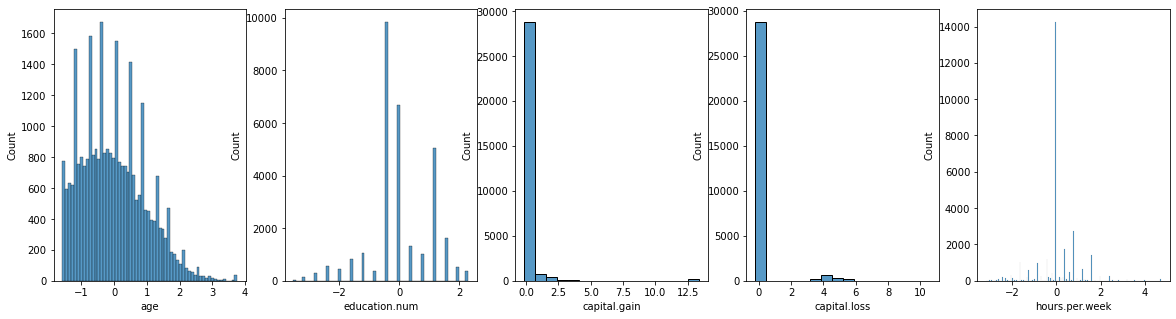

In [11]:
disp_feats = data.dtypes[data.dtypes == 'float64'].index.to_list()
fig, axes = plt.subplots(1, 5, figsize=(20, 5))
for i in range(len(disp_feats)):
    sns.histplot(data[disp_feats[i]], ax=axes[i], kde_kws={'bw':0.1})

#### Создаю датафрейм с корреляцией между признаками и таргетом

In [12]:
params = []
correlation = []
abs_corr = []
for c in data.columns:
    if c != 'income':
        if data[c].nunique() <= 2:
            corr = spearmanr(data['income'], data[c])[0]
        else:
            corr = pointbiserialr(data['income'], data[c])[0]
        params.append(c)
        correlation.append(corr)
        abs_corr.append(abs(corr))
        
params_df = pd.DataFrame({
    'correlation': correlation,
    'parameters': params,
    'abs_corr': abs_corr
})
params_df = params_df.sort_values(by=['abs_corr'], ascending=False).set_index('parameters')
params_df

,correlation,abs_corr
parameters,,
marital.status_Married-civ-spouse,0.445418,0.445418
relationship_Husband,0.401236,0.401236
education.num,0.335286,0.335286
marital.status_Never-married,-0.320053,0.320053
age,0.241998,0.241998
...,...,...
native.country_Cuba,0.002919,0.002919
native.country_Ireland,-0.002649,0.002649
education_Assoc-acdm,0.002170,0.002170


#### Отбрасываю признаки, которые слабо коррелируют с таргетом

In [13]:
print(data.shape)

feat_slice = params_df[params_df['abs_corr'] >= 0.1].index.to_list()

print(data[feat_slice].shape)
data[feat_slice].head()

(30162, 105)
(30162, 25)


,marital.status_Married-civ-spouse,relationship_Husband,education.num,marital.status_Never-married,age,hours.per.week,relationship_Own-child,capital.gain,sex_1,sex_2,...,occupation_Other-service,education_Prof-school,capital.loss,relationship_Unmarried,workclass_Self-emp-inc,education_HS-grad,marital.status_Divorced,education_Doctorate,relationship_Wife,workclass_Private
1,0,0,-0.420060,0,3.183112,-1.817204,0,-0.14592,1,0,...,0,0,10.593507,0,0,1,0,0,0,1
3,0,0,-2.363558,0,1.130359,-0.035429,0,-0.14592,1,0,...,0,0,9.461864,1,0,0,1,0,0,1
4,0,0,-0.031360,0,0.177296,-0.035429,1,-0.14592,1,0,...,0,0,9.461864,0,0,0,0,0,0,1
5,0,0,-0.420060,0,-0.335892,0.369519,0,-0.14592,1,0,...,1,0,9.139246,1,0,1,1,0,0,1
6,0,0,-1.586158,0,-0.042642,-0.035429,0,-0.14592,0,1,...,0,0,9.139246,1,0,0,0,0,0,1


In [14]:
# X = data.drop('income', axis=1)
# y = data['income']

X = data[feat_slice]
y = data['income']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, 
                                                    test_size=0.33, shuffle=True)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((20208, 25), (9954, 25), (20208,), (9954,))

### RandomForestClassifier

Провожу кроссвалидацию StratifiedKFold, разбивая на 5 фолдов, каждый раз перемешивая данные.

In [16]:
rf_preds = []
roc_auc = []
i = 1
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
skf.get_n_splits(X.index, y)

for train_index, test_index in skf.split(X.index, y):
    print(f'\n{i} of fold {skf.n_splits}')
    xtr, xvl = X[X.index.isin(train_index)], X[X.index.isin(test_index)]
    ytr, yvl = y[y.index.isin(train_index)], y[y.index.isin(test_index)]

    rf = RandomForestClassifier(n_estimators=500, max_depth=9,
                                random_state=42, min_samples_leaf=5,
                                n_jobs=-1)
    rf.fit(xtr, ytr)
    pred = rf.predict(xvl)
    pred_proba = rf.predict_proba(xvl)[:, 1]
    print(f'accuracy_score = {accuracy_score(yvl, pred)}')
    print(f'roc_auc_score = {roc_auc_score(yvl, pred_proba)}')
    rf_preds.append(accuracy_score(yvl, pred))
    roc_auc.append(roc_auc_score(yvl, pred_proba))
    i += 1


1 of fold 5
accuracy_score = 0.8544246993358463
roc_auc_score = 0.9137063182303583

2 of fold 5
accuracy_score = 0.8497777777777777
roc_auc_score = 0.9133289427747782

3 of fold 5
accuracy_score = 0.8675920982381207
roc_auc_score = 0.9181425431264157

4 of fold 5
accuracy_score = 0.8550179211469534
roc_auc_score = 0.9118199050242779

5 of fold 5
accuracy_score = 0.8564498742364355
roc_auc_score = 0.9121847472874509


Берем среднее значение из всех предсказаний.

In [17]:
# accuracy score
rf_score = np.array(rf_preds).mean(axis=0)
rf_score

0.8566524741470267

In [18]:
# roc_auc score
roc_auc_rf_score = np.array(roc_auc).mean(axis=0)
roc_auc_rf_score

0.9138364912886562

### Logistic Regression

In [19]:
lr_preds = []
roc_auc = []
i = 1
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
skf.get_n_splits(X.index, y)

for train_index, test_index in skf.split(X.index, y):
    print(f'\n{i} of fold {skf.n_splits}')
    xtr, xvl = X[X.index.isin(train_index)], X[X.index.isin(test_index)]
    ytr, yvl = y[y.index.isin(train_index)], y[y.index.isin(test_index)]

    lr = LogisticRegression(random_state=42, penalty='l1',
                            solver='liblinear', C=0.05)
    
    lr.fit(xtr, ytr)
    pred = lr.predict(xvl)
    pred_proba = lr.predict_proba(xvl)[:, 1] 
    print(f'accuracy_score = {accuracy_score(yvl, pred)}')
    print(f'roc_auc_score = {roc_auc_score(yvl, pred_proba)}')
    lr_preds.append(accuracy_score(yvl, pred))
    roc_auc.append(roc_auc_score(yvl, pred_proba))
    i += 1


1 of fold 5
accuracy_score = 0.8409621252916891
roc_auc_score = 0.9016066840032987

2 of fold 5
accuracy_score = 0.8421333333333333
roc_auc_score = 0.902231238423782

3 of fold 5
accuracy_score = 0.8522868837871508
roc_auc_score = 0.9038859375732577

4 of fold 5
accuracy_score = 0.8406810035842294
roc_auc_score = 0.8979913297141806

5 of fold 5
accuracy_score = 0.8424362199065757
roc_auc_score = 0.9024101814034962


In [20]:
# accuracy score
lr_score = np.array(lr_preds).mean(axis=0)
lr_score

0.8436999131805957

In [21]:
# roc_auc score
roc_auc_lr_score = np.array(roc_auc).mean(axis=0)
roc_auc_lr_score

0.901625074223603

### GaussianNaiveBayes

In [22]:
gnb_preds = []
roc_auc = []
i = 1
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
skf.get_n_splits(X.index, y)

for train_index, test_index in skf.split(X.index, y):
    print(f'\n{i} of fold {skf.n_splits}')
    xtr, xvl = X[X.index.isin(train_index)], X[X.index.isin(test_index)]
    ytr, yvl = y[y.index.isin(train_index)], y[y.index.isin(test_index)]
    
    gnb = GaussianNB()
    gnb.fit(xtr, ytr)
    pred = gnb.predict(xvl)
    pred_proba = gnb.predict_proba(xvl)[:, 1]
    print(f'accuracy_score = {accuracy_score(yvl, pred)}')
    print(f'roc_auc_score = {roc_auc_score(yvl, pred_proba)}')
    gnb_preds.append(accuracy_score(yvl, pred))
    roc_auc.append(roc_auc_score(yvl, pred_proba))
    i += 1


1 of fold 5
accuracy_score = 0.8255250403877221
roc_auc_score = 0.8890242013293403

2 of fold 5
accuracy_score = 0.8282666666666667
roc_auc_score = 0.8878066412490289

3 of fold 5
accuracy_score = 0.8229222281544759
roc_auc_score = 0.8827409293957769

4 of fold 5
accuracy_score = 0.8204301075268817
roc_auc_score = 0.8867649215700057

5 of fold 5
accuracy_score = 0.8219547251167805
roc_auc_score = 0.8866907660949572


In [23]:
# accuracy score
gnb_score = np.array(gnb_preds).mean(axis=0)
gnb_score

0.8238197535705053

In [24]:
# roc_auc score
roc_auc_gnb_score = np.array(roc_auc).mean(axis=0)
roc_auc_gnb_score

0.8866054919278218

### CatBoostClassifier

In [28]:
cat_preds = []
i = 1
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
skf.get_n_splits(X.index, y)

for train_index, test_index in skf.split(X.index, y):
    print(f'\n{i} of fold {skf.n_splits}')
    xtr, xvl = X[X.index.isin(train_index)], X[X.index.isin(test_index)]
    ytr, yvl = y[y.index.isin(train_index)], y[y.index.isin(test_index)]
    
    cat_model = CatBoostClassifier(random_state=42)
    
    cat_model.fit(xtr, ytr, eval_set=(xvl, yvl), verbose=10)
    pred = cat_model.predict_proba(xvl)[:, 1]
    cat_preds.append(roc_auc_score(yvl, pred))
    i += 1


1 of fold 5
Learning rate set to 0.108145
0:	learn: 0.5911828	test: 0.5912841	best: 0.5912841 (0)	total: 13.6ms	remaining: 13.6s
10:	learn: 0.3437388	test: 0.3449135	best: 0.3449135 (10)	total: 163ms	remaining: 14.7s
20:	learn: 0.3150609	test: 0.3173936	best: 0.3173936 (20)	total: 299ms	remaining: 13.9s
30:	learn: 0.3043962	test: 0.3086376	best: 0.3086376 (30)	total: 456ms	remaining: 14.3s
40:	learn: 0.2982176	test: 0.3033915	best: 0.3033915 (40)	total: 586ms	remaining: 13.7s
50:	learn: 0.2932511	test: 0.3001538	best: 0.3001538 (50)	total: 733ms	remaining: 13.6s
60:	learn: 0.2900171	test: 0.2979323	best: 0.2979323 (60)	total: 866ms	remaining: 13.3s
70:	learn: 0.2872657	test: 0.2962676	best: 0.2962676 (70)	total: 1.02s	remaining: 13.3s
80:	learn: 0.2843290	test: 0.2941820	best: 0.2941820 (80)	total: 1.15s	remaining: 13.1s
90:	learn: 0.2819268	test: 0.2933732	best: 0.2933732 (90)	total: 1.3s	remaining: 13s
100:	learn: 0.2781597	test: 0.2902616	best: 0.2902616 (100)	total: 1.44s	remainin

930:	learn: 0.2175629	test: 0.2917657	best: 0.2850413 (391)	total: 14.9s	remaining: 1.1s
940:	learn: 0.2172309	test: 0.2916336	best: 0.2850413 (391)	total: 15.1s	remaining: 945ms
950:	learn: 0.2167015	test: 0.2918522	best: 0.2850413 (391)	total: 15.3s	remaining: 786ms
960:	learn: 0.2164175	test: 0.2919054	best: 0.2850413 (391)	total: 15.4s	remaining: 627ms
970:	learn: 0.2160079	test: 0.2922101	best: 0.2850413 (391)	total: 15.7s	remaining: 468ms
980:	learn: 0.2155901	test: 0.2926847	best: 0.2850413 (391)	total: 15.8s	remaining: 306ms
990:	learn: 0.2151521	test: 0.2926231	best: 0.2850413 (391)	total: 16s	remaining: 145ms
999:	learn: 0.2147395	test: 0.2928855	best: 0.2850413 (391)	total: 16.2s	remaining: 0us

bestTest = 0.2850412612
bestIteration = 391

Shrink model to first 392 iterations.

2 of fold 5
Learning rate set to 0.108118
0:	learn: 0.5972818	test: 0.5986080	best: 0.5986080 (0)	total: 20.2ms	remaining: 20.1s
10:	learn: 0.3416587	test: 0.3494984	best: 0.3494984 (10)	total: 199ms	

840:	learn: 0.2190968	test: 0.2970748	best: 0.2907028 (303)	total: 13s	remaining: 2.47s
850:	learn: 0.2186507	test: 0.2973029	best: 0.2907028 (303)	total: 13.2s	remaining: 2.31s
860:	learn: 0.2181536	test: 0.2974488	best: 0.2907028 (303)	total: 13.3s	remaining: 2.15s
870:	learn: 0.2177246	test: 0.2977664	best: 0.2907028 (303)	total: 13.5s	remaining: 1.99s
880:	learn: 0.2174474	test: 0.2980088	best: 0.2907028 (303)	total: 13.6s	remaining: 1.84s
890:	learn: 0.2171283	test: 0.2980084	best: 0.2907028 (303)	total: 13.7s	remaining: 1.68s
900:	learn: 0.2167805	test: 0.2980976	best: 0.2907028 (303)	total: 13.9s	remaining: 1.52s
910:	learn: 0.2164654	test: 0.2982034	best: 0.2907028 (303)	total: 14s	remaining: 1.37s
920:	learn: 0.2160905	test: 0.2986383	best: 0.2907028 (303)	total: 14.1s	remaining: 1.21s
930:	learn: 0.2156870	test: 0.2988689	best: 0.2907028 (303)	total: 14.3s	remaining: 1.06s
940:	learn: 0.2152727	test: 0.2988577	best: 0.2907028 (303)	total: 14.4s	remaining: 904ms
950:	learn: 0.

740:	learn: 0.2281002	test: 0.2784598	best: 0.2747739 (328)	total: 12.1s	remaining: 4.24s
750:	learn: 0.2275861	test: 0.2786459	best: 0.2747739 (328)	total: 12.3s	remaining: 4.08s
760:	learn: 0.2270850	test: 0.2786856	best: 0.2747739 (328)	total: 12.5s	remaining: 3.93s
770:	learn: 0.2265959	test: 0.2790269	best: 0.2747739 (328)	total: 12.7s	remaining: 3.77s
780:	learn: 0.2263423	test: 0.2791932	best: 0.2747739 (328)	total: 12.9s	remaining: 3.61s
790:	learn: 0.2258784	test: 0.2791702	best: 0.2747739 (328)	total: 13s	remaining: 3.44s
800:	learn: 0.2252209	test: 0.2790953	best: 0.2747739 (328)	total: 13.2s	remaining: 3.27s
810:	learn: 0.2246951	test: 0.2793101	best: 0.2747739 (328)	total: 13.3s	remaining: 3.1s
820:	learn: 0.2243295	test: 0.2795289	best: 0.2747739 (328)	total: 13.4s	remaining: 2.93s
830:	learn: 0.2239058	test: 0.2797805	best: 0.2747739 (328)	total: 13.6s	remaining: 2.76s
840:	learn: 0.2237047	test: 0.2799460	best: 0.2747739 (328)	total: 13.7s	remaining: 2.59s
850:	learn: 0

640:	learn: 0.2306512	test: 0.2888453	best: 0.2876213 (330)	total: 11s	remaining: 6.15s
650:	learn: 0.2300388	test: 0.2889815	best: 0.2876213 (330)	total: 11.1s	remaining: 5.96s
660:	learn: 0.2294021	test: 0.2892621	best: 0.2876213 (330)	total: 11.3s	remaining: 5.77s
670:	learn: 0.2290046	test: 0.2892941	best: 0.2876213 (330)	total: 11.4s	remaining: 5.58s
680:	learn: 0.2286737	test: 0.2892974	best: 0.2876213 (330)	total: 11.5s	remaining: 5.4s
690:	learn: 0.2282417	test: 0.2893581	best: 0.2876213 (330)	total: 11.7s	remaining: 5.21s
700:	learn: 0.2278981	test: 0.2893590	best: 0.2876213 (330)	total: 11.8s	remaining: 5.04s
710:	learn: 0.2273621	test: 0.2897387	best: 0.2876213 (330)	total: 11.9s	remaining: 4.85s
720:	learn: 0.2269390	test: 0.2900195	best: 0.2876213 (330)	total: 12.1s	remaining: 4.67s
730:	learn: 0.2264366	test: 0.2901301	best: 0.2876213 (330)	total: 12.2s	remaining: 4.49s
740:	learn: 0.2260697	test: 0.2902857	best: 0.2876213 (330)	total: 12.4s	remaining: 4.32s
750:	learn: 0

550:	learn: 0.2349332	test: 0.2870070	best: 0.2844299 (233)	total: 8.47s	remaining: 6.9s
560:	learn: 0.2343483	test: 0.2871490	best: 0.2844299 (233)	total: 8.64s	remaining: 6.76s
570:	learn: 0.2337966	test: 0.2872912	best: 0.2844299 (233)	total: 8.83s	remaining: 6.63s
580:	learn: 0.2334199	test: 0.2873518	best: 0.2844299 (233)	total: 8.99s	remaining: 6.48s
590:	learn: 0.2330263	test: 0.2873916	best: 0.2844299 (233)	total: 9.13s	remaining: 6.32s
600:	learn: 0.2324704	test: 0.2874562	best: 0.2844299 (233)	total: 9.27s	remaining: 6.15s
610:	learn: 0.2320396	test: 0.2875960	best: 0.2844299 (233)	total: 9.41s	remaining: 5.99s
620:	learn: 0.2317650	test: 0.2877574	best: 0.2844299 (233)	total: 9.54s	remaining: 5.82s
630:	learn: 0.2313393	test: 0.2878708	best: 0.2844299 (233)	total: 9.69s	remaining: 5.67s
640:	learn: 0.2309314	test: 0.2880074	best: 0.2844299 (233)	total: 9.83s	remaining: 5.51s
650:	learn: 0.2304831	test: 0.2880277	best: 0.2844299 (233)	total: 9.99s	remaining: 5.35s
660:	learn:

In [29]:
cat_score = np.array(cat_preds).mean(axis=0)
cat_score

0.9276168925630308

### DecisionTreeClassifier

Точность алгоритмов по метрике AUC:
<ul>
    <li>RandomForest: 91.4%</li>
    <li>LogisticRegression: 90.0%</li>
    <li>GaussianNB: 88.7%</li>
    <li>CatBoostClassifier: 92.7%</li>
    <li>DecisionTreeClassifier</li>
</ul>